# Fasttext for financial entity classification
Applied to classifying names into:
* fund
* company
* bond

In [1]:
#!pip install fasttext
#!pip install pandas
#!pip instal openxml
#pip install scikit-learn
#!pip install matplotlib
#!pip install seaborn

## Dataset

In [2]:
import pandas as pd
import random

def get_data():
    
    df = pd.read_excel(io="company_bond_fund.xlsx", sheet_name="dataset")
    
    companies = df["company"][:4000]
    bonds = df["bond"][:4000]
    etfs = df["etf"][:4000]
    funds = df["fund"][:4000]

    data = []
    for i,_ in enumerate(companies):
        data.append(("company",companies[i]))
        data.append(("bond", bonds[i]))
        data.append(("etf", etfs[i]))
        data.append(("fund", funds[i]))

    random.shuffle(data)
    return data

data = get_data()
len(data)

16000

## Preprocessing

In [3]:
import re

def preprocess(raw):
    """ preprocess string or list of strings"""

    def tune(string):
        string =  str(string).replace("%", " % ")
        string = string.replace(";"," ")
        string = string.replace(","," ")
        string = string.replace("."," ")
        string = string.replace(":"," ")
        string = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", string).strip()
        return string
    
    if isinstance(raw, list):
        res = []
        for string in raw:
            string = tune(string)
            res.append(string)
        return res
    else:
        return tune(str(raw))


## Writing as fasttext compatible dataset

In [4]:
# preprocess data
for i,(l,d) in enumerate(data):
    d_mod = preprocess(d)
    data[i] = l,d_mod
    if i%1003==0:
        print(data[i])

('bond', 'APHM 3   187  %  9 NOV 37')
('company', 'Punjab National Bank')
('fund', 'Schwab Capital Trust  Schwab Total Stock Market Index Fund')
('company', 'Fifth Third Bank')
('etf', 'Global X FTSE Southeast Asia ETF')
('bond', 'ENGIE 1   5  %  13 MAR 35')
('etf', 'Global X Telemedicine & Digital Health ETF')
('etf', 'WBI Bull|Bear Trend Switch US  3000  Total Return ETF')
('bond', 'CASA 1   7  %  7 MAY 2029')
('company', 'AmerisourceBergen')
('company', 'CONSOL Coal Resources')
('bond', 'CRE 0   4 - 1   2  %  29 APR 22')
('bond', 'CASA 4   2  %  29 MAY 34')
('etf', 'iPath Series B Bloomberg Industrial Metals Subindex Total Return ETN')
('etf', 'iShares MSCI Peru ETF')
('etf', 'iShares MSCI UAE ETF')


In [5]:
train, test, val =  data[0:10000], data[10000:12000], data[12000:14000]

In [6]:
def write_data(data, name):
    file = open(name,"w+")
    for l,d in data:
        file.write(f"__label__{l} {d}\n")
    

write_data(train,"fasttext_train.txt" )
write_data(test,"fasttext_test.txt" )
write_data(val,"fasttext_validate.txt" )

## Training

In [7]:
import fasttext
model = fasttext.train_supervised('fasttext_train.txt')
model.labels

['__label__company', '__label__fund', '__label__bond', '__label__etf']

## Testing

In [8]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*model.test('fasttext_test.txt'))

N	2000
P@1	0.991
R@1	0.991


In [13]:
names = [x[1] for x in test]
labels = ["__label__"+x[0] for x in test]

# predict the data
predicted = list(map(lambda x: model.predict(x)[0][0], names))


/home/jerome/miniconda3/envs/fund_classifier/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['__label__company', '__label__fund', '__label__etf', '__label__bond'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


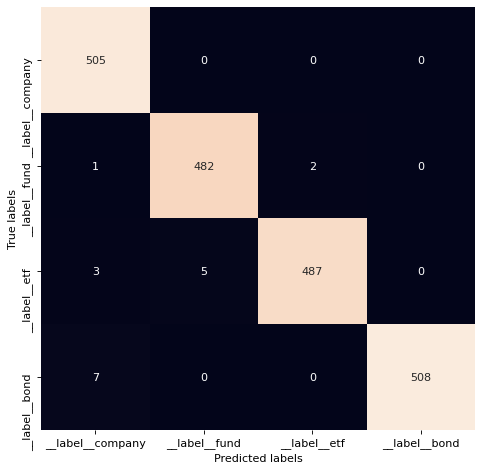

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix

def draw_cm(predicted_test, predicted):
    labels = list(set(predicted_test + predicted))
    cm = confusion_matrix(predicted_test, predicted, labels)
    fig = plt.figure(figsize=(7,7), dpi=80)
    ax= fig.add_subplot(111)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cbar=False);  
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
draw_cm(labels, predicted)

## Validation

In [10]:
model.predict("test")

(('__label__company',), array([1.00000811]))

In [16]:
model.predict(preprocess(["Amazon", "Google", "some fund", "EU 5 % 2020"]))

([['__label__company'],
  ['__label__company'],
  ['__label__company'],
  ['__label__bond']],
 [array([0.99870664], dtype=float32),
  array([1.0000079], dtype=float32),
  array([1.0000079], dtype=float32),
  array([1.0000077], dtype=float32)])

In [17]:
print_results(*model.test("fasttext_validate.txt"))

N	2000
P@1	0.995
R@1	0.995


## Saving model

In [201]:
#model.quantize(input='fasttext_train.txt', retrain=True)
model.save_model("security_classifier.ftz")